In [1]:
!pip install --upgrade --no-cache-dir gdown >/dev/null
!gdown 1-OCBGBtKoY_PadKHcXDyWxHQ2BS8Nulo

Downloading...
From: https://drive.google.com/uc?id=1-OCBGBtKoY_PadKHcXDyWxHQ2BS8Nulo
To: /content/bigdata_hw1_files.zip
100% 38.9M/38.9M [00:00<00:00, 239MB/s]


In [2]:
!unzip bigdata_hw1_files.zip

Archive:  bigdata_hw1_files.zip
   creating: hw1-files/
   creating: hw1-files/q3/
  inflating: hw1-files/q3/patches.csv  
  inflating: hw1-files/q3/lsh.py     
   creating: hw1-files/q1/
  inflating: hw1-files/q1/dataset1.txt  
   creating: hw1-files/q1/.ipynb_checkpoints/
   creating: hw1-files/q2/
  inflating: hw1-files/q2/games_library.txt  
   creating: hw1-files/.ipynb_checkpoints/


In [3]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
#Modified: Alex Porter
import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import matplotlib.pyplot as plt

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    # Manhattan distance
    d = 0
    for i in range(len(v)):
        d += abs(u[i] - v[i])
    return d

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0,
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold,
                                   high = max_threshold + 1,
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as
# possible, since it is expensive.
# A: The dataset in which each row is an image patch.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)

    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors], [t[1] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    # Extract Query Vector
    query_vect = A[query_index]

    # Compute Distance to Each
    distances = []
    for index,row in enumerate(A):

        # don't include the query
        if index == query_index:
            continue

        # Extract the relevant data from the row
        distance = l1(query_vect, row)

        # This elimination step only works once we found n candidates
        if len(distances) >= num_neighbors:
            # Don't bother adding if it's farther than all "current best" neighbors
            if distance > distances[-1][1]:
                continue

        # Insert in sorted order to optimize
        idx = 0
        for i in range(len(distances)):
            if distances[i][1] > distance:
                idx = i
                break
        distances = distances[:idx] + [[index, distance]] + distances[idx: num_neighbors - 1]
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]
    return [t[0] for t in best_neighbors], [t[1] for t in best_neighbors]

# TODO: Write a function that computes the error measure
def lsh_error(lsh_dists, linear_dists):
    return sum(lsh_dists) / sum(linear_dists)

# TODO: Solve Problem 3
def problem3():
    raise NotImplementedError

#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded,
    ### but you may find them helpful)


# if __name__ == '__main__':
# #    unittest.main() ### TODO: Uncomment this to run tests
#     # problem3()

In [4]:
A = load_data('hw1-files/q3/patches.csv')

In [5]:
L = 10
K = 24
functions, hashed_A = lsh_setup(A, k=K, L=L)

In [6]:
QUERY_INDICES = (100, 199, 300, 399, 500, 599, 700, 799, 900, 999)
NEIGHBORS = 3

In [7]:
# Section 2

lsh_dists = []
linear_dists = []

print('*** LSH:')
times = []
for i in QUERY_INDICES:
    ts = time.time()
    neighboers, distances = lsh_search(A, hashed_A, functions, i, NEIGHBORS)
    times.append(time.time() - ts)
    lsh_dists.append(distances)
    print(i, ':', neighboers)
print('Mean LSH Elapsed Time:', np.mean(times))

print('\n')

print('*** Linear Search:')
times = []
for i in QUERY_INDICES:
    ts = time.time()
    neighboers, distances = linear_search(A, i, NEIGHBORS)
    times.append(time.time() - ts)
    linear_dists.append(distances)
    print(i, ':', neighboers)
print('Mean Linear Search Elapsed Time:', np.mean(times))

*** LSH:
100 : [7551, 8196, 28351]
199 : [42509, 38136, 11148]
300 : [15818, 22057, 9006]
399 : [37216, 24449, 45671]
500 : [1178, 557, 35904]
599 : [23640, 59469, 54275]
700 : [44006, 36422, 90]
799 : [46059, 57201, 12962]
900 : [29023, 15184, 20405]
999 : [51830, 26772, 5325]
Mean LSH Elapsed Time: 0.5233157396316528


*** Linear Search:
100 : [7551, 8196, 28351]
199 : [39397, 11341, 23895]
300 : [15818, 22057, 9006]
399 : [20536, 18874, 20572]
500 : [1178, 557, 35904]
599 : [6201, 47784, 9540]
700 : [41352, 44006, 36422]
799 : [33741, 13889, 24319]
900 : [29023, 15184, 20405]
999 : [46093, 28450, 59238]
Mean Linear Search Elapsed Time: 9.121149230003358


In [8]:
# Section 3
print('Error:', np.mean([lsh_error(lsh_dists[i], linear_dists[i]) for i in range(len(QUERY_INDICES))]))

Error: 1.0674393454071922


In [9]:
# Section 4.1

K = 24
L = list(range(10, 22, 2))
errors = []

for l in L:
    functions, hashed_A = lsh_setup(A, k=K, L=l)
    lsh_errors = []
    for i in QUERY_INDICES:
        lsh_dists = lsh_search(A, hashed_A, functions, i, NEIGHBORS)[1]
        linear_dists = linear_search(A, i, NEIGHBORS)[1]
        lsh_errors.append(lsh_error(lsh_dists, linear_dists))
    errors.append(np.mean(lsh_errors))

L: [10, 12, 14, 16, 18, 20]
Error: [1.0653477395760862, 1.0069369728033153, 1.0423111893376034, 1.0318895142049824, 1.025285894388745, 1.0449073258365529]


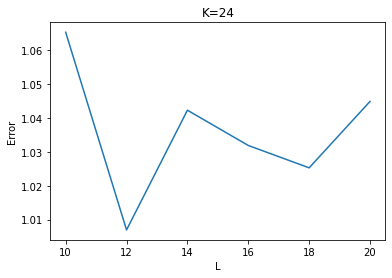

In [10]:
print('L:', L)
print('Error:', errors)

plt.plot(L, errors)
plt.title("K=24")
plt.xlabel("L")
plt.ylabel("Error")
plt.show()

In [11]:
# Section 4.2

K = list(range(16, 26, 2))
L = 10
errors = []

for k in K:
    functions, hashed_A = lsh_setup(A, k=k, L=L)
    lsh_errors = []
    for i in QUERY_INDICES:
        lsh_dists = lsh_search(A, hashed_A, functions, i, NEIGHBORS)[1]
        linear_dists = linear_search(A, i, NEIGHBORS)[1]
        lsh_errors.append(lsh_error(lsh_dists, linear_dists))
    errors.append(np.mean(lsh_errors))

K: [16, 18, 20, 22, 24]
Error: [1.0136615383643273, 1.0160704982339392, 1.0157113537512217, 1.0756084938641712, 1.0730879555254238]


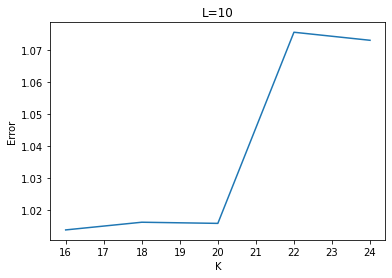

In [12]:
print('K:', K)
print('Error:', errors)

plt.plot(K, errors)
plt.title("L=10")
plt.xlabel("K")
plt.ylabel("Error")
plt.show()

In [22]:
L = 10
K = 24
functions, hashed_A = lsh_setup(A, k=K, L=L)

In [23]:
# Section 5

QUERY_INDEX = 100
NEIGHBORS = 10

lsh_neighbors = lsh_search(A, hashed_A, functions, QUERY_INDEX, NEIGHBORS)[0]
linear_neighbors = linear_search(A, QUERY_INDEX, NEIGHBORS)[0]

plot(A, [QUERY_INDEX], 'original')
plot(A, lsh_neighbors, 'lsh')
plot(A, linear_neighbors, 'linear')

In [24]:
print(linear_neighbors)
print(lsh_neighbors)

[7551, 8196, 28351, 28251, 25289, 21780, 22509, 12444, 25549, 7464]
[7551, 8196, 28351, 28251, 25289, 21780, 22509, 12444, 25549, 7464]
